In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)


Running on: cuda


In [5]:
!pip install -q kaggle
import os
import zipfile
import torch
import torchvision
from torchvision import datasets, transforms
!pip install matplotlib

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
!pip install scikit-learn
from sklearn.model_selection import train_test_split



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 89.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 87.2 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
!apt update && apt install unzip -y

!unzip -q rock_paper_scissors_dataset.zip.zip -d /workspace/


Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]3m
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]  
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]    
Get:6 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.8 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1792 kB]     
Get:10 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [55.7 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1553 kB]m
Get:13 http://arc

In [9]:
data_path = "/workspace/rock_paper_scissors/"
transform = transforms.Compose([
  transforms.Resize((64,64)),
  transforms.ToTensor(),
]
)

dataset = datasets.ImageFolder(root=data_path, transform=transform)

from torch.utils.data import random_split 

train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset,[train_size,test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader =DataLoader(test_dataset,batch_size=32)
print("Classes:", dataset.classes)



Classes: ['paper', 'rock', 'scissors']


In [10]:
class SimpleConvNet(nn.Module):
  def __init__(self, in_channels=3 , out_channels=1 , kernel_size=3 , stride = 1,padding = 1):
    super(SimpleConvNet,self).__init__()
    self.conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding)

  def forward(self,x):
    return self.conv(x)

  

In [11]:
image , label = dataset[0]
image = image.unsqueeze(0)
print("Input size: ",image.shape)

model = SimpleConvNet(in_channels=3,out_channels=1,kernel_size=3,stride=1,padding=1)
output = model(image)
print("Output size: " ,output.shape)


Input size:  torch.Size([1, 3, 64, 64])
Output size:  torch.Size([1, 1, 64, 64])


In [12]:
import numpy as np

# Define custom 3x3 kernels
blur_kernel = torch.tensor([[1,1,1],[1,1,1],[1,1,1]], dtype=torch.float32) / 9
sharpen_kernel = torch.tensor([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=torch.float32)
edge_kernel = torch.tensor([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]], dtype=torch.float32)

# Wrap into Conv2D weights format: [out_channels, in_channels, kernel_size, kernel_size]
def create_custom_conv(kernel):
    conv = nn.Conv2d(3, 1, kernel_size=3, padding=1, bias=False)
    kernel = kernel.view(1, 1, 3, 3).repeat(1, 3, 1, 1)  # Repeat for 3 input channels
    conv.weight.data = kernel
    return conv

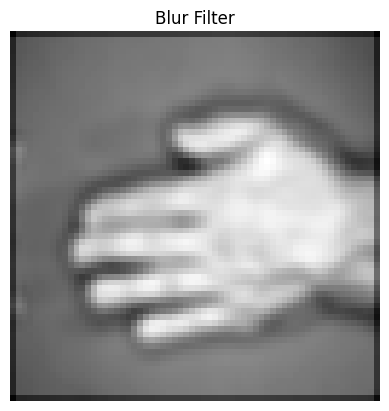

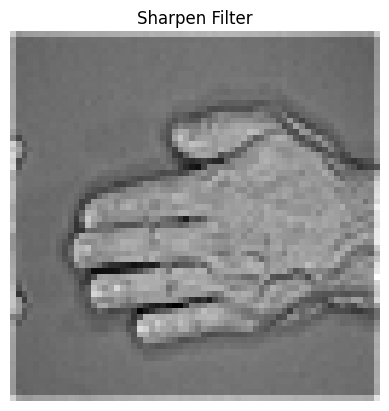

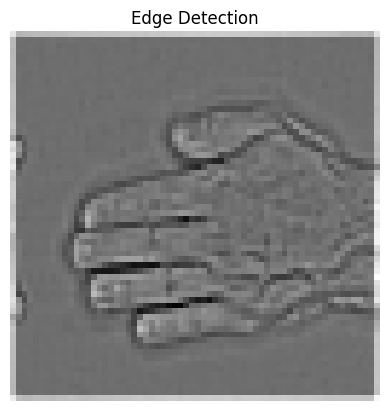

In [13]:
import matplotlib.pyplot as plt

def visualize_feature_map(image, conv_layer, title):
    with torch.no_grad():
        output = conv_layer(image)
        plt.imshow(output[0][0].numpy(), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

# Input image
img = image  # shape [1, 3, 64, 64]

# Apply and visualize
visualize_feature_map(img, create_custom_conv(blur_kernel), "Blur Filter")
visualize_feature_map(img, create_custom_conv(sharpen_kernel), "Sharpen Filter")
visualize_feature_map(img, create_custom_conv(edge_kernel), "Edge Detection")

In [14]:
# Larger kernel
model_large_kernel = SimpleConvNet(in_channels=3, out_channels=1, kernel_size=5, stride=1, padding=2)
print("Output with 5x5 kernel:", model_large_kernel(image).shape)

# Stride 2 (reduces spatial size)
model_stride2 = SimpleConvNet(in_channels=3, out_channels=1, kernel_size=3, stride=2, padding=1)
print("Output with stride=2:", model_stride2(image).shape)

# No padding
model_no_padding = SimpleConvNet(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=0)
print("Output with no padding:", model_no_padding(image).shape)


Output with 5x5 kernel: torch.Size([1, 1, 64, 64])
Output with stride=2: torch.Size([1, 1, 32, 32])
Output with no padding: torch.Size([1, 1, 62, 62])


In [15]:
class ConvWithPooling(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1):
    super(ConvWithPooling,self).__init__()
    self.conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
  
  def forward(self,x):
    conv_out = self.conv(x)
    pooled_out = self.pool(conv_out)
    return conv_out, pooled_out


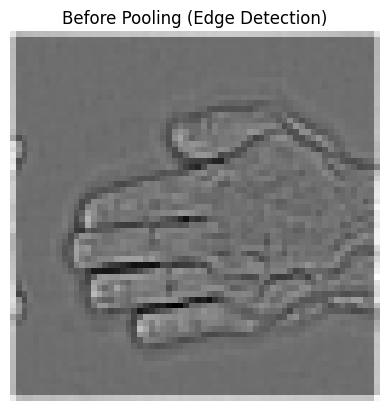

Shape before pooling: torch.Size([1, 1, 64, 64])


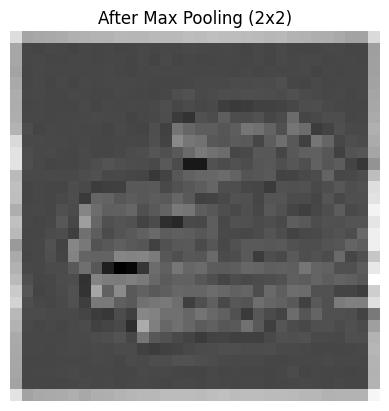

Shape after pooling: torch.Size([1, 1, 32, 32])


In [16]:
model = ConvWithPooling()

# Use edge detection kernel for clarity
edge_kernel = torch.tensor([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]], dtype=torch.float32)
kernel = edge_kernel.view(1, 1, 3, 3).repeat(1, 3, 1, 1)  # 3-channel input
model.conv.weight.data = kernel
model.conv.bias.data.zero_()

# Run on one image
image, label = dataset[0]
image = image.unsqueeze(0)  # [1, 3, 64, 64]
conv_out, pooled_out = model(image)

# Visualize
def show_tensor(tensor, title):
    plt.imshow(tensor.squeeze().detach().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_tensor(conv_out, "Before Pooling (Edge Detection)")
print("Shape before pooling:", conv_out.shape)

show_tensor(pooled_out, "After Max Pooling (2x2)")
print("Shape after pooling:", pooled_out.shape)


In [17]:
class GAPConvNet(nn.Module):
    def __init__(self):
        super(GAPConvNet, self).__init__()
        self.conv = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)  # 8 filters
        self.gap = nn.AdaptiveAvgPool2d((8,8))  # Output: [B, C, 1, 1]

    def forward(self, x):
        conv_out = self.conv(x)
        gap_out = self.gap(conv_out)
        return conv_out, gap_out


In [18]:
model = GAPConvNet()
conv_out, gap_out = model(image)

print("Conv output shape:", conv_out.shape)  # [1, 8, 64, 64]
print("GAP output shape:", gap_out.shape)    # [1, 8, 1, 1]


Conv output shape: torch.Size([1, 8, 64, 64])
GAP output shape: torch.Size([1, 8, 8, 8])


In [19]:
gap_out_flat = gap_out.view(gap_out.size(0), -1)  # shape: [1, 8]
print("Flattened GAP shape:", gap_out_flat.shape)


Flattened GAP shape: torch.Size([1, 512])


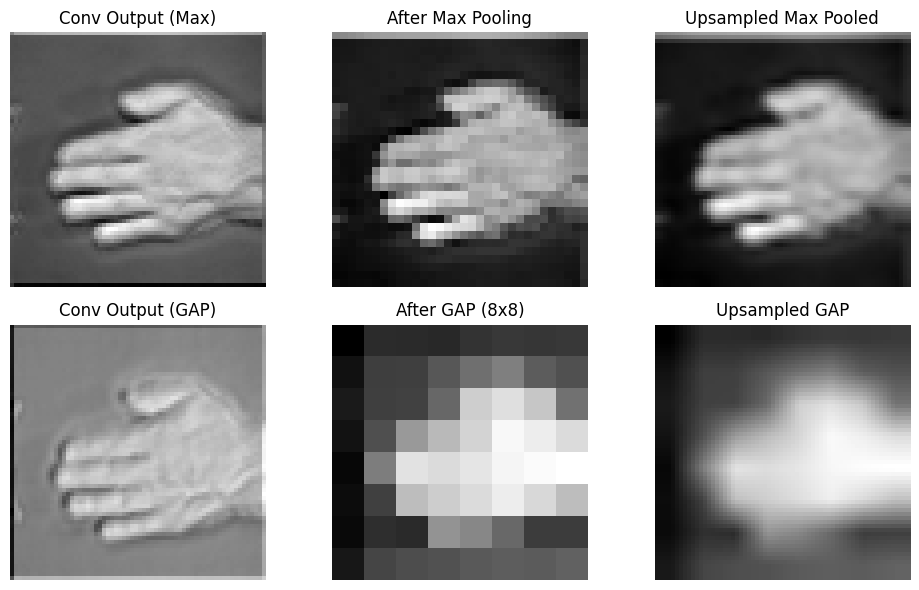

In [20]:
image, _ = dataset[0]
image = image.unsqueeze(0)

# Initialize models
max_model = ConvWithPooling()
gap_model = GAPConvNet()

# Models
max_model = ConvWithPooling()
gap_model = GAPConvNet()

# Outputs
conv_max, max_pooled = max_model(image)
conv_gap, gap_pooled = gap_model(image)

# Plot
plt.figure(figsize=(10, 6))

# 1. Original Conv Output
plt.subplot(2, 3, 1)
plt.imshow(conv_max[0, 0].detach().numpy(), cmap='gray')
plt.title("Conv Output (Max)")
plt.axis('off')

# 2. After Max Pooling
plt.subplot(2, 3, 2)
plt.imshow(max_pooled[0, 0].detach().numpy(), cmap='gray')
plt.title("After Max Pooling")
plt.axis('off')

# 3. Upsampled Max Pooled (for fair comparison)
plt.subplot(2, 3, 3)
upsampled_max = nn.functional.interpolate(max_pooled, size=conv_max.shape[2:], mode='bilinear')
plt.imshow(upsampled_max[0, 0].detach().numpy(), cmap='gray')
plt.title("Upsampled Max Pooled")
plt.axis('off')

# 4. Original Conv Output (GAP)
plt.subplot(2, 3, 4)
plt.imshow(conv_gap[0, 0].detach().numpy(), cmap='gray')
plt.title("Conv Output (GAP)")
plt.axis('off')

# 5. After GAP (8x8 map)
plt.subplot(2, 3, 5)
plt.imshow(gap_pooled[0, 0].detach().numpy(), cmap='gray')
plt.title("After GAP (8x8)")
plt.axis('off')

# 6. Upsampled GAP
plt.subplot(2, 3, 6)
upsampled_gap = nn.functional.interpolate(gap_pooled, size=conv_gap.shape[2:], mode='bilinear')
plt.imshow(upsampled_gap[0, 0].detach().numpy(), cmap='gray')
plt.title("Upsampled GAP")
plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
class RockPaperScissorCNN(nn.Module):
  def __init__(self,input_shape=(3,64,64),num_classes=3):
    super(RockPaperScissorCNN,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1)
    self.pool1 = nn.MaxPool2d(2,2)

    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.pool2 = nn.MaxPool2d(2,2)

    self.conv3 = nn.Conv2d(32,64,3,padding=1)
    self.pool3 = nn.MaxPool2d(2,2)

    self.gap = nn.AdaptiveAvgPool2d((1,1))

    self.fc1 = nn.Linear(64,32)
    self.fc2 = nn.Linear(32,num_classes)

  def forward(self,x):
    #print("Input shape:", x.shape)

    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    #print("After Conv1+ReLU+Pool:", x.shape)

    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    #print("After Conv2+ReLU+Pool:", x.shape)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool3(x)
    #print("After Conv3+ReLU+Pool:", x.shape)

    x = self.gap(x)
    #print("After GAP:", x.shape)

    x = x.view(x.size(0), -1)  # Flatten to [B, 64]
    #print("After Flatten:", x.shape)

    x = self.fc1(x)
    x = F.relu(x)
    #print("After FC1+ReLU:", x.shape)

    x = self.fc2(x)
    #print("After FC2 (pre-softmax):", x.shape)

    x = F.softmax(x, dim=1)
    #print("After Softmax:", x.shape)

    return x

In [27]:
# Simulate one sample from dataset (3, 64, 64)
sample_image, _ = dataset[0]
sample_image = sample_image.unsqueeze(0)  # Shape: [1, 3, 64, 64]

model = RockPaperScissorCNN()
output = model(sample_image)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RockPaperScissorCNN().to(device)
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)




In [29]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [30]:
train_acc_list = []
test_acc_list = []

epochs = 10
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate after each epoch
    train_acc = evaluate(model, train_loader)
    test_acc = evaluate(model, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/10, Train Acc: 0.3480, Test Acc: 0.3219
Epoch 2/10, Train Acc: 0.3480, Test Acc: 0.3219
Epoch 3/10, Train Acc: 0.3480, Test Acc: 0.3219
Epoch 4/10, Train Acc: 0.3480, Test Acc: 0.3219
Epoch 5/10, Train Acc: 0.3480, Test Acc: 0.3219
Epoch 6/10, Train Acc: 0.3480, Test Acc: 0.3219
Epoch 7/10, Train Acc: 0.3480, Test Acc: 0.3219
Epoch 8/10, Train Acc: 0.3480, Test Acc: 0.3219
Epoch 9/10, Train Acc: 0.3480, Test Acc: 0.3219
Epoch 10/10, Train Acc: 0.3480, Test Acc: 0.3219


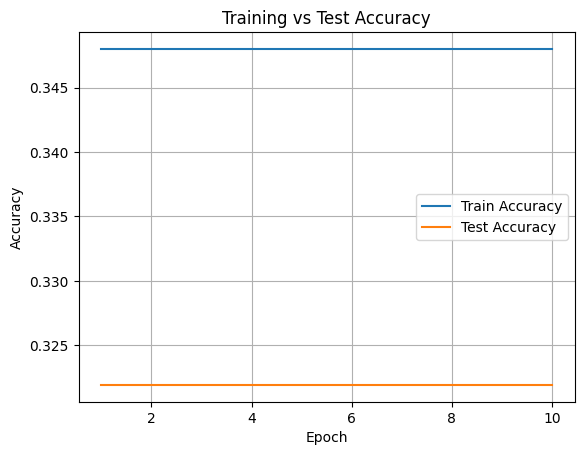

In [31]:
plt.plot(range(1, epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()
